# XGBoost Classification - Explanation and Adance techniques

This notebook will progress through a classification problem of classifying NBA positions. The data set will have 5 NBA positions, or 5 categories. The models will progress from the most basic to more advanced techniques, focusing on hyperparameter optimization. Additionally, tools will be utilized to evaluate which features the models are using to produce their classifications.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder

# this will be used to access the bigquery client
from google.cloud import bigquery
# this will be used to access the service account modules - passwords and access tokens
from google.oauth2 import service_account
# this will be used for returning data, increases the speed
from google.cloud import bigquery_storage
# for os library
import os

# required for certain returns
import pandas_gbq
# exception for a short script
from google.api_core.exceptions import NotFound

c:\Users\nick\AppData\Local\Programs\Python\Python310\lib\site-packages\google\api_core\_python_version_support.py:275: FutureWarning: You are using a Python version (3.10.7) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)
c:\Users\nick\AppData\Local\Programs\Python\Python310\lib\site-packages\google\api_core\_python_version_support.py:275: FutureWarning: You are using a Python version (3.10.7) which Google will stop supporting in new releases of google.cloud.bigquery_storage_v1 once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.cloud.bigquery_storage_v1 past that date.
  warnings.warn(message, FutureWarning)


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder

# this will be used to access the bigquery client
from google.cloud import bigquery
# this will be used to access the service account modules - passwords and access tokens
from google.oauth2 import service_account
# this will be used for returning data, increases the speed
from google.cloud import bigquery_storage
# for os library
import os

# required for certain returns
import pandas_gbq
# exception for a short script
from google.api_core.exceptions import NotFound

# Connect and query the data base from Google Cloud Platform

In [2]:
# Path to service account if stored locally
SERVICE_ACCOUNT_JSON = r"..\portfolio2026-485323-70c4d609b156.json"

# Credentials to access Big Query via the service account
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_JSON)

# BigQuery client
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# BigQuery Storage client
bq_storage_client = bigquery_storage.BigQueryReadClient(credentials=credentials)

# Query the complete data set
query = """
SELECT *
FROM `portfolio2026-485323.portfolio1.df50`
"""

# Execute the query and use the bqstorage for faster data retrieval
df50 = client.query(query).to_dataframe(bqstorage_client=bq_storage_client)

# Dsiplay the data
display(df50.head())

,player,age,year,tm,pos,g,gs,mp,fg,fga,...,drb,trb,ast,stl,blk,tov,pf,pts,3p_,2p_
0,Clint Capela,26,2021,ATL,C,63,63,1898,413,695,...,606,903,49,44,129,73,145,956,NaN,0.594245
1,Clint Capela,27,2022,ATL,C,74,73,2042,370,604,...,598,877,92,55,93,44,166,820,0.0,0.613599
2,Clint Capela,28,2023,ATL,C,65,63,1730,350,536,...,459,717,58,45,79,54,139,779,0.0,0.654206
3,Clint Capela,30,2024,ATL,C,55,41,1176,218,390,...,295,469,62,34,53,47,106,488,0.0,0.560411
4,Onyeka Okongwu,20,2021,ATL,C,50,4,601,96,149,...,101,163,18,23,33,29,100,228,0.0,0.657534


# Perform Classification using XGBoost

Classify the position of an NBA player. First we will remove the few players that have mixed positions.

In [3]:
df50['pos'].unique()

array(['C', 'PF', 'PG', 'SF', 'SG'], dtype=object)

In [4]:
df50['pos'].value_counts()

pos
SG    276
PF    225
PG    213
C     210
SF    210
Name: count, dtype: int64

# We will utilize the X data and y data

X will consist of our numeric features
y will be a numeric encoding of the 'pos' categorical variable. There are 5 positions.

In [5]:
X = df50.copy() # label X for convention

# Encode the categorical target
le = LabelEncoder()
X.loc[:,'Pos_encoded'] = le.fit_transform(X.loc[:,'pos']) # type:ignore

y=X['Pos_encoded'].copy()

X = X.select_dtypes('number').copy()

X.drop(columns='Pos_encoded',inplace=True)

# XGBoost Classifier for NBA positions

Here I will utilize the XGBoost Classifier. The model is a tree model. It will progress by splitting the data multiple times based on features, such as above or below Feature 1 and the value of 10. The model will continue to split upon features to a depth parameter. The model will work to classify the data with the evaluation metric provided. 



Train, validation, and test splits are used for the data to prevent data leakage. The training data will be used to train the model. The model will then be validated on the validation data. So, during the training process the model will evaluate itself on the validation data. I will implement an early stopping round such that if the model doesn't improve on this validation data after 10 rounds the model will stop. This prevents the model from overfitting and continuing to train on the data past improvements.



In [6]:
# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize and train XGBoost model
model = xgb.XGBClassifier(
    n_estimators=500,
    early_stopping_rounds=10,
    eval_metric= 'mlogloss',              # multiclass log loss
    learning_rate=0.1, 
    max_depth=3,
    random_state=42                          
)  # for classification

# model = xgb.XGBRegressor()  # use this for regression tasks
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)


# Make predictions and evaluate
y_pred = model.predict(X_test)

# Evaluate (choose the right metric)
print("Accuracy:", accuracy_score(y_test, y_pred))
# For regression: print("MSE:", mean_squared_error(y_test, y_pred))

Accuracy: 0.6387665198237885


In [7]:
probs = model.predict_proba(X_test)

# Get predicted class
predicted_class = np.argmax(probs, axis=1)

# Map back to labels if needed
final_predictions = le.inverse_transform(predicted_class)

In [8]:
np.round(probs, decimals=2)[:10]

array([[0.01, 0.08, 0.13, 0.24, 0.54],
       [0.  , 0.  , 0.06, 0.11, 0.82],
       [0.67, 0.28, 0.  , 0.04, 0.  ],
       [0.  , 0.01, 0.97, 0.01, 0.02],
       [0.01, 0.44, 0.07, 0.4 , 0.08],
       [0.25, 0.7 , 0.01, 0.03, 0.  ],
       [0.  , 0.02, 0.92, 0.03, 0.03],
       [0.97, 0.03, 0.  , 0.  , 0.  ],
       [0.01, 0.04, 0.13, 0.14, 0.69],
       [0.02, 0.28, 0.02, 0.48, 0.21]], dtype=float32)

In [9]:
# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Use 'macro', 'weighted', or 'micro' depending on your goal
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

# Optional: 'weighted' is often good if classes are imbalanced
# print("Precision (weighted):", precision_score(y_test, y_pred, average='weighted'))

# Classification report handles all classes
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Precision (macro): 0.6220933602347761
Recall (macro): 0.6375887075887074
F1 Score (macro): 0.6240808095476572

Classification Report:
               precision    recall  f1-score   support

           C       0.82      0.93      0.87        44
          PF       0.62      0.46      0.53        54
          PG       0.79      0.82      0.80        45
          SF       0.34      0.28      0.31        39
          SG       0.53      0.69      0.60        45

    accuracy                           0.64       227
   macro avg       0.62      0.64      0.62       227
weighted avg       0.63      0.64      0.63       227



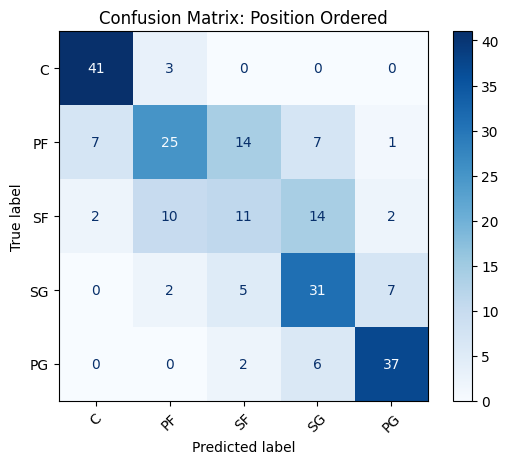

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Custom class order
custom_order = ['C', 'PF', 'SF', 'SG', 'PG']

# Convert custom label order to integer label indices
custom_indices = le.transform(custom_order)

# Compute confusion matrix in desired label order
cm = confusion_matrix(y_test, y_pred, labels=custom_indices)

# Display with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=custom_order)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: Position Ordered")
plt.grid(False)
plt.show()


In [11]:
# Class index 0 corresponds to this label:
print(le.inverse_transform([0,1,2,3,4]))  # e.g., ['C']

['C' 'PF' 'PG' 'SF' 'SG']


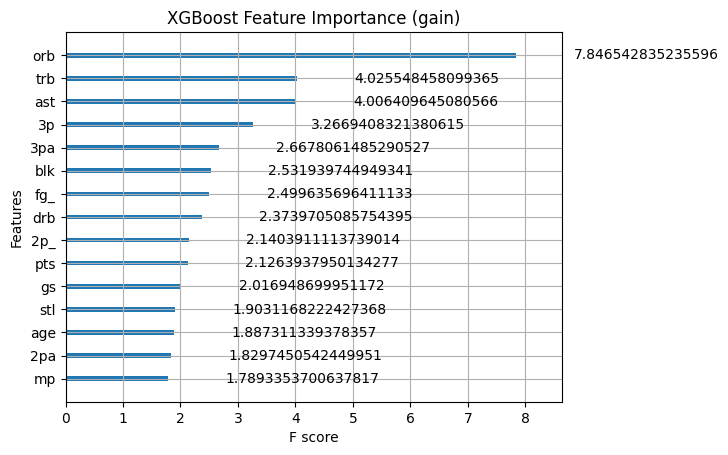

In [12]:
from xgboost import plot_importance

# Plot feature importance (based on model gain)
plot_importance(model, importance_type='gain', max_num_features=15)
plt.title('XGBoost Feature Importance (gain)')
plt.show()

In [13]:
importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

display(importance_df.head(10))

,Feature,Importance
14,orb,7.846543
16,trb,4.025548
17,ast,4.006410
8,3p,3.266941
9,3pa,2.667806
19,blk,2.531940
7,fg_,2.499636
15,drb,2.373971
24,2p_,2.140391
22,pts,2.126394


In [14]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Train dummy model
dummy = DummyClassifier(strategy='uniform')  # or 'stratified', 'uniform','most_frequent'
dummy.fit(X_train, y_train)

# Step 2: Predict and evaluate
y_dummy_pred = dummy.predict(X_test)

print("Dummy Model Accuracy:", accuracy_score(y_test, y_dummy_pred))
print("\nDummy Classification Report:\n", classification_report(y_test, y_dummy_pred, target_names=le.classes_))

Dummy Model Accuracy: 0.2290748898678414

Dummy Classification Report:
               precision    recall  f1-score   support

           C       0.23      0.25      0.24        44
          PF       0.29      0.22      0.25        54
          PG       0.27      0.31      0.29        45
          SF       0.12      0.15      0.13        39
          SG       0.25      0.20      0.22        45

    accuracy                           0.23       227
   macro avg       0.23      0.23      0.23       227
weighted avg       0.24      0.23      0.23       227



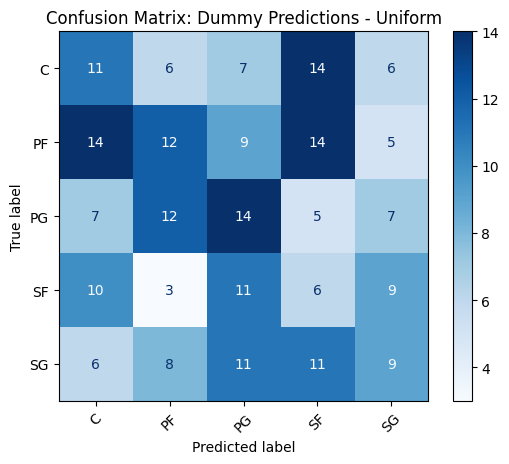

In [49]:
cm_dummy = confusion_matrix(y_test, y_dummy_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dummy, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: Dummy Predictions - Uniform")
plt.grid(False)
plt.show()

# Analyze with SHAP if preferred

In [47]:
# import shap

In [46]:
# # Optional: silence warnings
# import warnings
# warnings.filterwarnings("ignore")

# # Step 1: Create SHAP explainer
# explainer = shap.Explainer(model)

# #Step 2: Compute SHAP values
# shap_values = explainer(X_test)

# # Step 3: Summary plot (global feature importance)
# shap.summary_plot(shap_values, X_test)

# Now do the advanced techniques of cross validation and hyperparameter tuning

# Cross validation

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import xgboost as xgb

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = []

for train_idx, val_idx in skf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = xgb.XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        early_stopping_rounds=20,
        random_state=42
    )

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    preds = model.predict(X_val)
    score = accuracy_score(y_val, preds)
    cv_scores.append(score)

print("CV Accuracy:", np.mean(cv_scores))


CV Accuracy: 0.6164360063935129


In [19]:
probs = model.predict_proba(X_test)

# Get predicted class
predicted_class = np.argmax(probs, axis=1)

# Map back to labels if needed
final_predictions = le.inverse_transform(predicted_class)

In [20]:
np.round(probs, decimals=2)[:10]

array([[0.  , 0.05, 0.08, 0.51, 0.36],
       [0.  , 0.  , 0.03, 0.08, 0.89],
       [0.1 , 0.82, 0.  , 0.08, 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.01, 0.33, 0.04, 0.52, 0.1 ],
       [0.74, 0.23, 0.01, 0.01, 0.  ],
       [0.  , 0.01, 0.96, 0.02, 0.02],
       [0.98, 0.02, 0.  , 0.  , 0.  ],
       [0.  , 0.03, 0.08, 0.07, 0.83],
       [0.01, 0.12, 0.02, 0.18, 0.67]], dtype=float32)

In [21]:
# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Use 'macro', 'weighted', or 'micro' depending on your goal
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

# Optional: 'weighted' is often good if classes are imbalanced
# print("Precision (weighted):", precision_score(y_test, y_pred, average='weighted'))

# Classification report handles all classes
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Precision (macro): 0.9500710594315246
Recall (macro): 0.9367521367521368
F1 Score (macro): 0.9402246778103782

Classification Report:
               precision    recall  f1-score   support

           C       0.98      1.00      0.99        44
          PF       0.90      1.00      0.95        54
          PG       0.98      0.93      0.95        45
          SF       1.00      0.79      0.89        39
          SG       0.90      0.96      0.92        45

    accuracy                           0.94       227
   macro avg       0.95      0.94      0.94       227
weighted avg       0.95      0.94      0.94       227



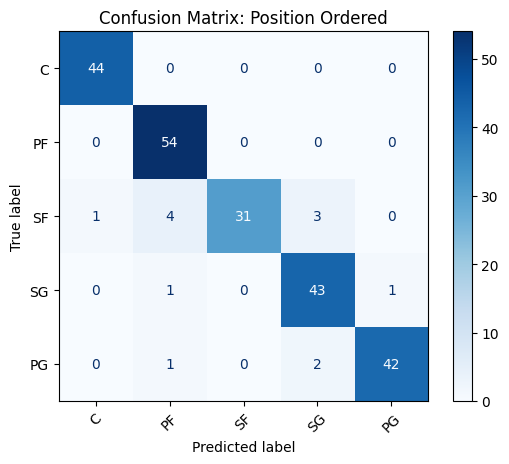

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Custom class order
custom_order = ['C', 'PF', 'SF', 'SG', 'PG']

# Convert custom label order to integer label indices
custom_indices = le.transform(custom_order)

# Compute confusion matrix in desired label order
cm = confusion_matrix(y_test, y_pred, labels=custom_indices)

# Display with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=custom_order)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: Position Ordered")
plt.grid(False)
plt.show()

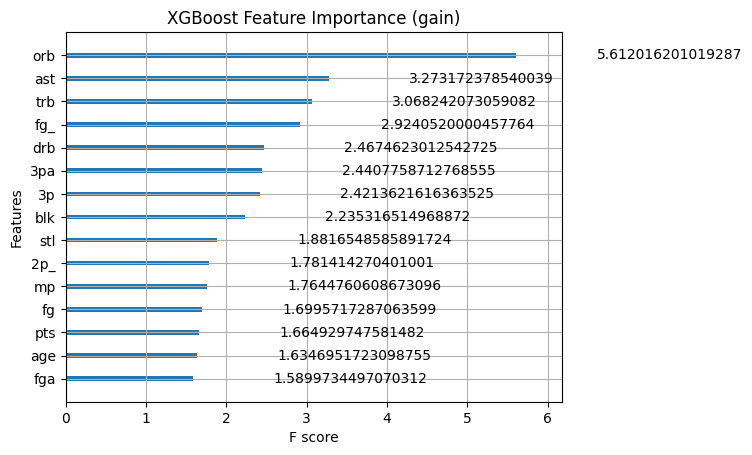

In [23]:
from xgboost import plot_importance

# Plot feature importance (based on model gain)
plot_importance(model, importance_type='gain', max_num_features=15)
plt.title('XGBoost Feature Importance (gain)')
plt.show()

# Analyze with SHAP if preferred

In [45]:
# # Optional: silence warnings
# import warnings
# warnings.filterwarnings("ignore")

# # Step 1: Create SHAP explainer
# explainer = shap.Explainer(model)

# #Step 2: Compute SHAP values
# shap_values = explainer(X_test)

# # Step 3: Summary plot (global feature importance)
# shap.summary_plot(shap_values, X_test)

# Now with Randomized Search and Cross Validation

When considering hyperparameter optimization, we must evaluate the number of combinations of hyperparameters. In this example we will use Randomized Search and utilize 30 different combinations of hyperparameters for efficiency. Using 6 hyperparameters and our value counts per hyperparameter there are 1296 combinations. Therefore, using grid search is not effective at scale for models with many hyperparameters.

I will use cross validation so each model will be fit across 5 train-test splits on the data. Considering our 30 different hyperparameter combinations, the process will produce 150 runs. The cross validation will take the mean of each models 5 fits and produce the best parameters based on this metric. In this case, we are using accuracy for our scoring metric. 

Another issue with Random or Grid Search is that as the model utilizes different hyperparameter combinations, the process isn't adaptively learning about which parameter changes are driving improvement. The next step to find the best hyperparameter combinations and to scale is to use another library built for finding the best parameters. We will use the library optuna for a better method of searching hyperparameter space.

In [25]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [200, 400, 600, 800],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.3]
}

xgb_model = xgb.XGBClassifier(
    eval_metric="mlogloss",
    random_state=42
)

search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring="accuracy",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X, y)

print("Best params:", search.best_params_)
print("Best CV score:", search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'subsample': 0.6, 'n_estimators': 800, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best CV score: 0.6067326809870961


In [26]:
xgb_model = xgb.XGBClassifier(
    **search.best_params_,
    eval_metric="mlogloss",
    random_state=42
)


In [27]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=800,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

array([[0.  , 0.01, 0.01, 0.87, 0.11],
       [0.  , 0.  , 0.  , 0.01, 0.98],
       [0.05, 0.92, 0.  , 0.03, 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.01, 0.1 , 0.02, 0.83, 0.05],
       [0.92, 0.07, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.98, 0.01, 0.01],
       [1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.03, 0.02, 0.93],
       [0.  , 0.02, 0.  , 0.03, 0.94]], dtype=float32)

Precision (macro): 0.9549568641462525
Recall (macro): 0.9463247863247863
F1 Score (macro): 0.9489504452216991

Classification Report:
               precision    recall  f1-score   support

           C       0.98      1.00      0.99        44
          PF       0.92      1.00      0.96        54
          PG       0.98      0.96      0.97        45
          SF       0.97      0.82      0.89        39
          SG       0.93      0.96      0.95        45

    accuracy                           0.95       227
   macro avg       0.95      0.95      0.95       227
weighted avg       0.95      0.95      0.95       227



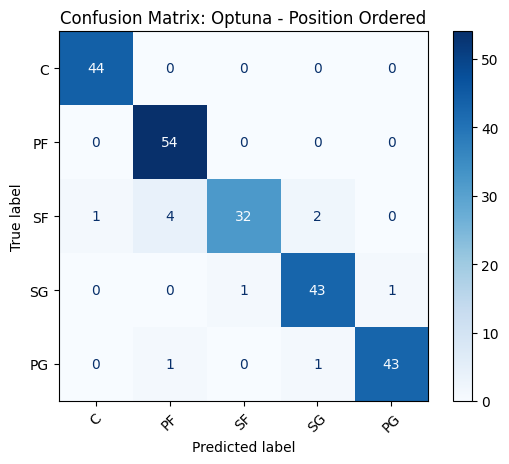

In [50]:
display(np.round(probs, decimals=2)[:10])

probs = xgb_model.predict_proba(X_test)

# Get predicted class
predicted_class = np.argmax(probs, axis=1)

# Map back to labels if needed
final_predictions = le.inverse_transform(predicted_class)

# Predictions
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Use 'macro', 'weighted', or 'micro' depending on your goal
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

# Optional: 'weighted' is often good if classes are imbalanced
# print("Precision (weighted):", precision_score(y_test, y_pred, average='weighted'))

# Classification report handles all classes
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Custom class order
custom_order = ['C', 'PF', 'SF', 'SG', 'PG']

# Convert custom label order to integer label indices
custom_indices = le.transform(custom_order)

# Compute confusion matrix in desired label order
cm = confusion_matrix(y_test, y_pred, labels=custom_indices)

# Display with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=custom_order)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: Optuna - Position Ordered")
plt.grid(False)
plt.show()

In [ ]:
# pip install optuna

If you can:

Explain why CV matters

Explain early stopping

Explain hyperparameter tradeoffs

You are already stronger than many entry-level candidates.

# Optuna and Hyperparameter Tuning

Optuna is an improvement on grid and randomized search becomes it adaptively learns from each trial. This means that the 30th trial has learned from the previous ones. This is based on the idea of the Optuna having an internal memory in its model that knows "Sample more like what already works, but don’t stop exploring". The model picks up on what parameters led to high performance metrics and continues to utilize those in future trials. In comparison to randomized search, randomized search jumps from parameter combination to parameter combination without considering the previous trials. 

In [31]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 0.5),
        "eval_metric": "mlogloss",
        "random_state": 42
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train, verbose=False)

        preds = model.predict(X_val)
        scores.append(accuracy_score(y_val, preds))

    return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)
print("Best score:", study.best_value)


[I 2026-02-01 14:10:12,748] A new study created in memory with name: no-name-d4a9f0ea-4766-4674-8e6c-4aa15132686f
[I 2026-02-01 14:10:18,921] Trial 0 finished with value: 0.6155081673229115 and parameters: {'n_estimators': 893, 'max_depth': 6, 'learning_rate': 0.12158522591126063, 'subsample': 0.9713288349359117, 'colsample_bytree': 0.7949696892329042, 'gamma': 0.0018325104853251228}. Best is trial 0 with value: 0.6155081673229115.
[I 2026-02-01 14:10:20,784] Trial 1 finished with value: 0.631406182994815 and parameters: {'n_estimators': 328, 'max_depth': 8, 'learning_rate': 0.1038165789997248, 'subsample': 0.9655887025223345, 'colsample_bytree': 0.9323036902416098, 'gamma': 0.4090345579860172}. Best is trial 1 with value: 0.631406182994815.
[I 2026-02-01 14:10:23,684] Trial 2 finished with value: 0.6216950606214182 and parameters: {'n_estimators': 348, 'max_depth': 5, 'learning_rate': 0.042741042940643174, 'subsample': 0.9538061507037063, 'colsample_bytree': 0.7137948922684058, 'gamma

Best params: {'n_estimators': 999, 'max_depth': 8, 'learning_rate': 0.09129364833642326, 'subsample': 0.7284944635271501, 'colsample_bytree': 0.9729907079497936, 'gamma': 0.20228289720902137}
Best score: 0.6508011383571791


In [32]:
study.best_params

{'n_estimators': 999,
 'max_depth': 8,
 'learning_rate': 0.09129364833642326,
 'subsample': 0.7284944635271501,
 'colsample_bytree': 0.9729907079497936,
 'gamma': 0.20228289720902137}

In [33]:
xgb_model_optuna = xgb.XGBClassifier(
    **study.best_params,
    eval_metric="mlogloss",
    random_state=42
)


In [34]:
xgb_model_optuna.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9729907079497936, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.20228289720902137, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09129364833642326,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=999, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [35]:
probs = xgb_model_optuna.predict_proba(X_test)

# Get predicted class
predicted_class = np.argmax(probs, axis=1)

# Map back to labels if needed
final_predictions = le.inverse_transform(predicted_class)

In [36]:
display(np.round(probs, decimals=2)[:10])

array([[0.  , 0.01, 0.01, 0.87, 0.11],
       [0.  , 0.  , 0.  , 0.01, 0.98],
       [0.05, 0.92, 0.  , 0.03, 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.01, 0.1 , 0.02, 0.83, 0.05],
       [0.92, 0.07, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.98, 0.01, 0.01],
       [1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.03, 0.02, 0.93],
       [0.  , 0.02, 0.  , 0.03, 0.94]], dtype=float32)

Precision (macro): 0.9610174702068586
Recall (macro): 0.9514529914529914
F1 Score (macro): 0.9545060007772547

Classification Report:
               precision    recall  f1-score   support

           C       0.98      1.00      0.99        44
          PF       0.92      1.00      0.96        54
          PG       0.98      0.96      0.97        45
          SF       1.00      0.85      0.92        39
          SG       0.93      0.96      0.95        45

    accuracy                           0.96       227
   macro avg       0.96      0.95      0.95       227
weighted avg       0.96      0.96      0.96       227



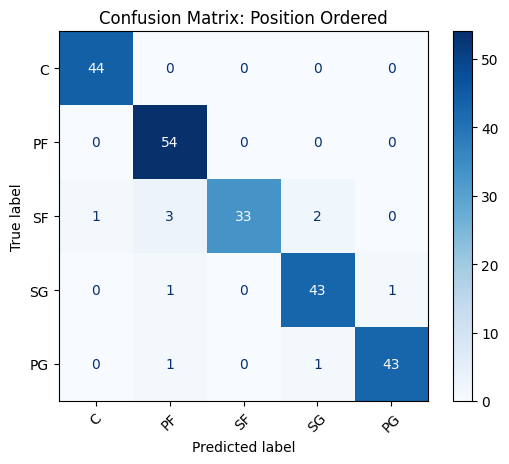

In [37]:
# Predictions
y_pred = xgb_model_optuna.predict(X_test)
y_proba = xgb_model_optuna.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Use 'macro', 'weighted', or 'micro' depending on your goal
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

# Optional: 'weighted' is often good if classes are imbalanced
# print("Precision (weighted):", precision_score(y_test, y_pred, average='weighted'))

# Classification report handles all classes
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Custom class order
custom_order = ['C', 'PF', 'SF', 'SG', 'PG']

# Convert custom label order to integer label indices
custom_indices = le.transform(custom_order)

# Compute confusion matrix in desired label order
cm = confusion_matrix(y_test, y_pred, labels=custom_indices)

# Display with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=custom_order)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: Position Ordered")
plt.grid(False)
plt.show()

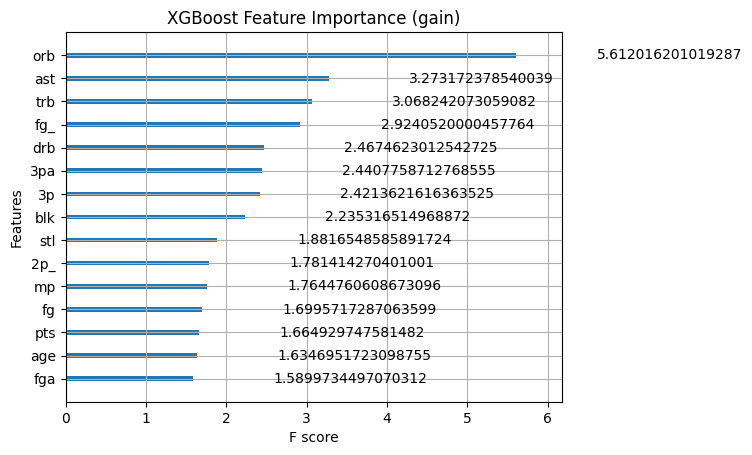

In [38]:
# Plot feature importance (based on model gain)
plot_importance(model, importance_type='gain', max_num_features=15)
plt.title('XGBoost Feature Importance (gain)')
plt.show()

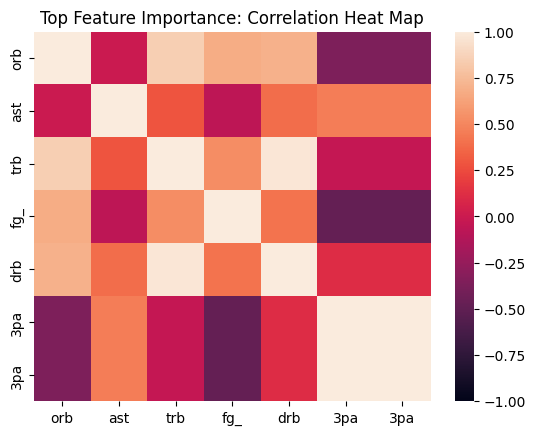

In [44]:
sns.heatmap(df50[['orb','ast','trb','fg_','drb','3pa','3pa']].corr(), vmin=-1, vmax=1)
plt.title('Top Feature Importance: Correlation Heat Map');